In [1]:
import torch; torch.manual_seed(0)
import torch.nn as nn
import torch.nn.functional as F
import torch.utils
import torch.distributions
import torchvision
import numpy as np
import torchvision.models as models 
from torchvision import transforms, utils
from torch.utils.data.sampler import SubsetRandomSampler
import torch.optim as optim
import matplotlib.pyplot as plt
import latent_plot as lp
from torch.autograd import Variable
from torch.optim import lr_scheduler
import os
os.environ['CUDA_LAUNCH_BLOCKING'] = '1'
import copy
#from model import VAE

import matplotlib.pyplot as plt; plt.rcParams['figure.dpi'] = 200
from data_loader import FundusDataLoader
from model import convVAE

In [2]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'

In [3]:
csv_path = '/home/vip/sayan-mandal/datasets/obj_criteria/20200619-objective.csv'
img_path = '/home/vip/sayan-mandal/datasets/obj_criteria/good_reduced/'

ResizeParam = 128
FD = FundusDataLoader(csv_path, img_path,transform=transforms.Compose([transforms.Resize(ResizeParam), transforms.ToTensor()]))

#random sampler
batch_size = 64


data_loader = torch.utils.data.DataLoader(FD, batch_size=batch_size, shuffle = True)

In [4]:
#vae model structure
model = convVAE((3,128,128),2048).cuda()
model.load_state_dict(torch.load('/home/vip/sayan-mandal/vae-savedmodels/bestdfcvae_inp128_nl2048_a1b1.torch'))
print(model)

convVAE(
  (encoder): Sequential(
    (0): Conv2d(3, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): LeakyReLU(negative_slope=0.01)
    (3): Conv2d(16, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
    (4): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): LeakyReLU(negative_slope=0.01)
    (6): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (7): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (8): LeakyReLU(negative_slope=0.01)
    (9): Conv2d(64, 16, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
    (10): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (11): LeakyReLU(negative_slope=0.01)
    (12): Flatten(start_dim=1, end_dim=-1)
  )
  (fc1): Sequential(
    (0): Linear(in_features=16384, out_features=4096, bias=True)
    (1): BatchNo

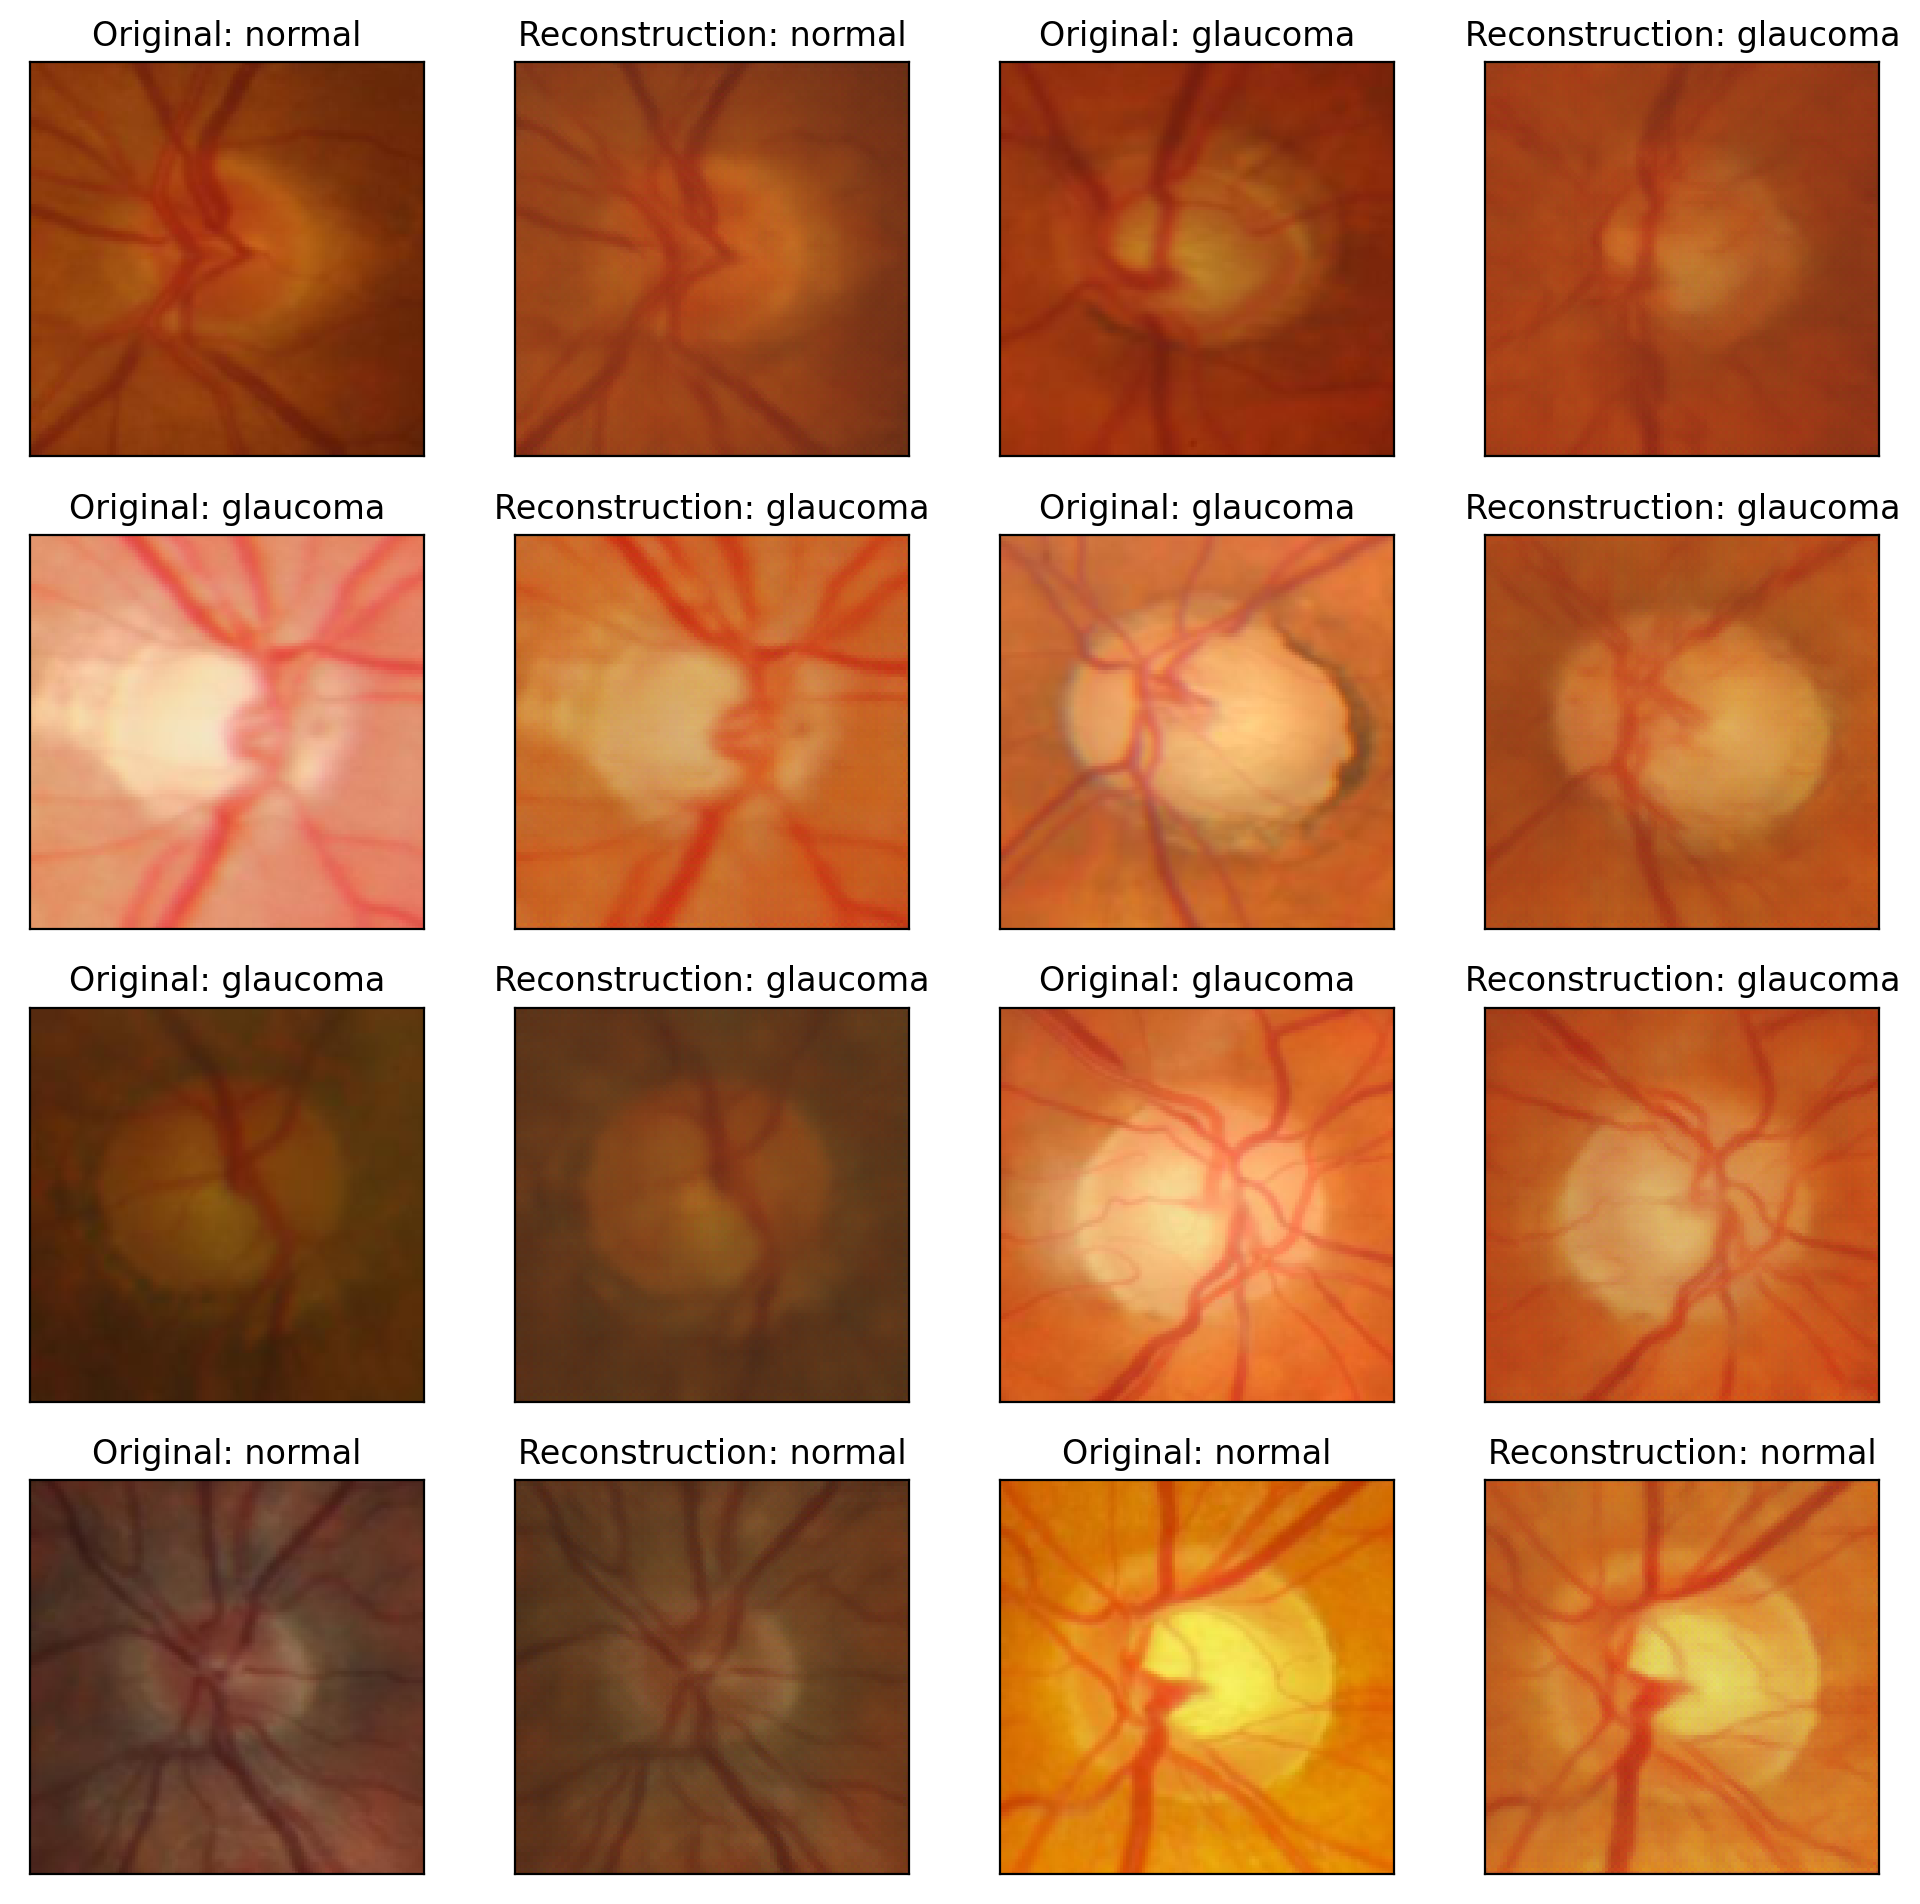

In [5]:
#Utility functions to un-normalize and display an image
def imshow(img):
    #img = img / 2 + 0.5  
    plt.imshow(np.transpose(img, (1, 2, 0))) 

#Define the image classes
classes = ['normal','glaucoma']

#Obtain one batch of training images
dataiter = iter(data_loader)
data, labels = dataiter.next()
model.eval()
images,_,_ = model(Variable(data).cuda())
images = images.detach().cpu().numpy() # convert images to numpy for display

#Plot the images
fig = plt.figure(figsize=(12, 12))
# display 20 images
idx = 0
while idx < 16:
    ax = fig.add_subplot(4,4, idx+1, xticks=[], yticks=[])
    imshow(data[idx])
    ax.set_title("Original: " + classes[labels[idx]])
    idx+=1
    ax = fig.add_subplot(4,4, idx+1, xticks=[], yticks=[])
    imshow(images[idx-1])
    ax.set_title("Reconstruction: " + classes[labels[idx-1]])
    idx+=1


In [6]:
from sklearn.manifold import TSNE

n_comp = 2
perplexity = 30

In [7]:

for i, (data,label) in enumerate(data_loader):
    y, _,_ =  model.encode(Variable(data).cuda())
    y = y.cpu().detach().numpy()
    if i == 0:
        yd = y
        lbl = label.numpy()
    else:
        yd = np.append(yd,y,axis=0)
        lbl = np.append(lbl,label.numpy(), axis=0)

In [8]:
y_embed = TSNE(n_components=n_comp, perplexity=perplexity).fit_transform(yd)
#labels = ['normal','glaucoma']

0
1


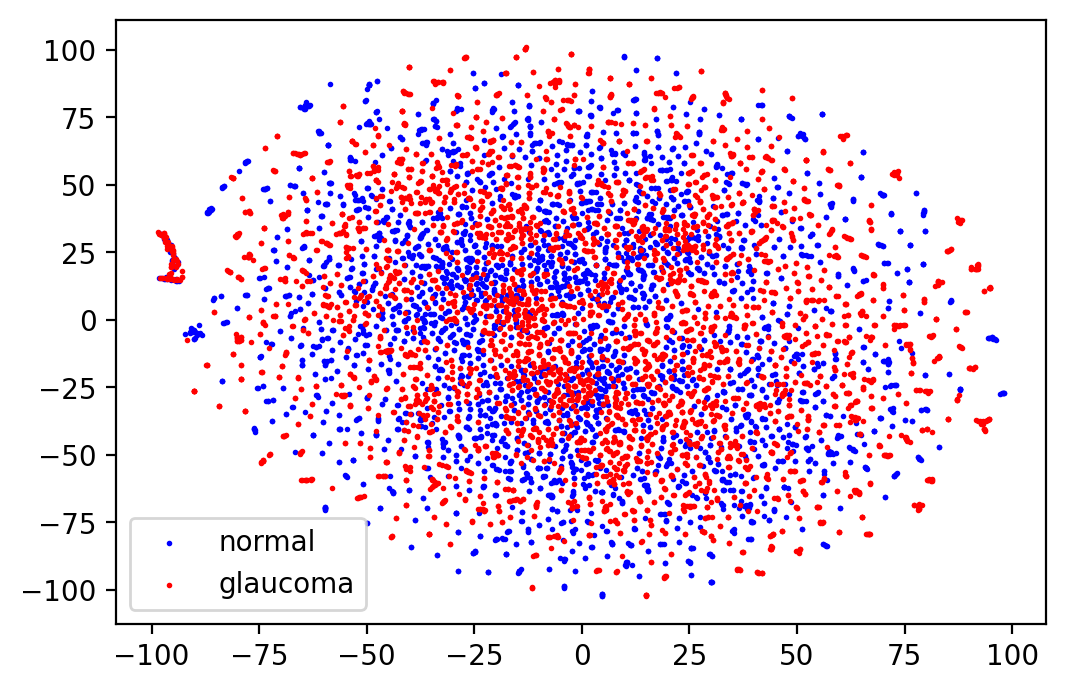

In [9]:
fig, ax = plt.subplots()
cdict = {0: 'blue', 1: 'red'}
for g in np.unique(lbl):
    print(g)
    idx = np.where(lbl == g)
    ax.scatter(y_embed[idx,0],y_embed[idx,1],c=cdict[g], label = classes[g], s = 1, alpha = 1)
ax.legend()
plt.show()